In [1]:
import anndata
import pandas as pd
import scanpy as sc
import scglue

/tmp/ipykernel_267677/3177959315.py:4: FutureWarning: X.dtype being converted to np.float32 from int32. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  rna.layers["counts"] = rna.X.copy()
/root/miniconda3/envs/sclab/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/root/miniconda3/envs/sclab/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/root/miniconda3/envs/sclab/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/root/miniconda3/envs/sclab/lib/python3.8/site-packag

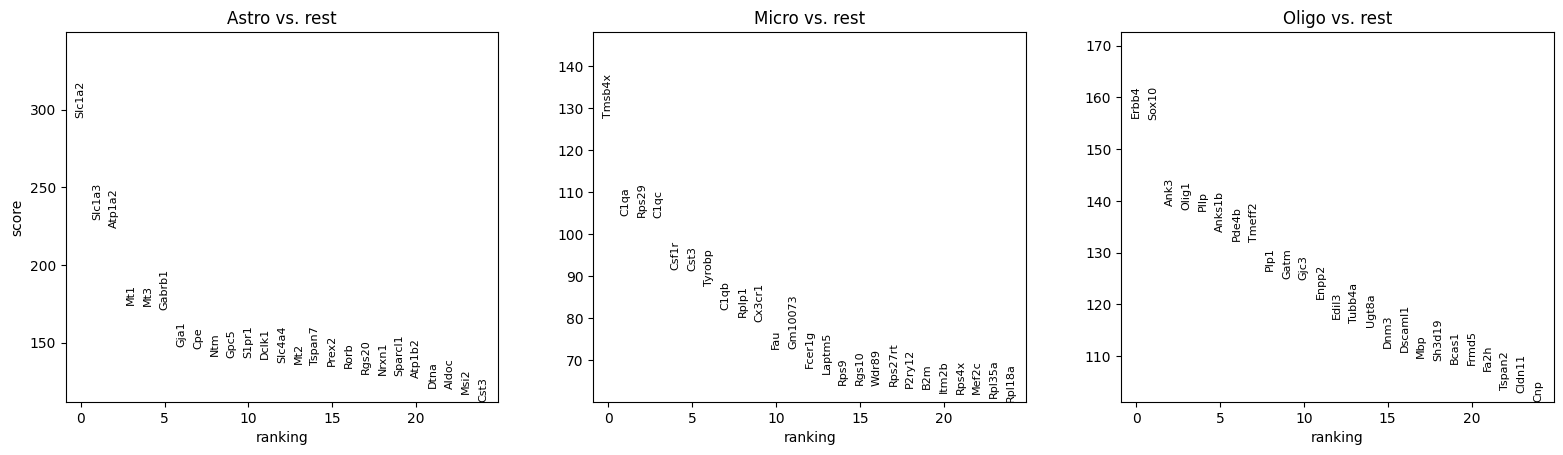

In [2]:
rna = anndata.read_h5ad("/lmh_data/data/sclab/Mouse_10x/scRNA.h5ad")
rna.obs.cell_type = rna.obs.cell_type.cat.rename_categories({'Micro-PVM': 'Micro'})
rna = rna[rna.obs['cell_type'].isin(['Astro', 'Micro', 'Oligo']),:]
rna.layers["counts"] = rna.X.copy()

scglue.data.get_gene_annotation(
    rna, gtf="/lmh_data/data/sclab/Mouse_10x/rsem_GRCm38.p3.gtf",
    gtf_by="gene_symbol"
)
rna = rna[:, rna.var.dropna(axis=0, how='all').index]

sc.pp.highly_variable_genes(rna, n_top_genes=2000, flavor="seurat_v3")
sc.pp.normalize_total(rna)
sc.pp.log1p(rna)
sc.pp.scale(rna)
sc.tl.pca(rna, n_comps=100, svd_solver="auto")

sc.tl.rank_genes_groups(rna, 'cell_type', method='t-test')
sc.pl.rank_genes_groups(rna, n_genes=25, sharey=False)

In [3]:
rank_genes_groups = pd.DataFrame(rna.uns['rank_genes_groups']['names'])[:100]
rank_genes_groups[:20]

,Astro,Micro,Oligo
0,Slc1a2,Tmsb4x,Erbb4
1,Slc1a3,C1qa,Sox10
2,Atp1a2,Rps29,Ank3
3,Mt1,C1qc,Olig1
4,Mt3,Csf1r,Pllp
5,Gabrb1,Cst3,Anks1b
6,Gja1,Tyrobp,Pde4b
7,Cpe,C1qb,Tmeff2
8,Ntm,Rplp1,Plp1
9,Gpc5,Cx3cr1,Gatm


In [4]:
marker_genes = pd.DataFrame()
for index, row in rank_genes_groups.iterrows():
    for cell_type in row.keys():
        marker_genes = pd.concat(
            [
                marker_genes, 
                pd.DataFrame(data=[[row[cell_type], '{}_{}'.format(cell_type, index)]], columns=['gene_name', 'rank'])
            ],
            ignore_index=True
        )
marker_genes = marker_genes.groupby('gene_name')['rank'].apply(list).reset_index(name='rank')
marker_genes = marker_genes.set_index('gene_name')
marker_genes

,rank
gene_name,
1700047M11Rik,[Oligo_74]
Abr,[Astro_98]
Acadl,[Micro_78]
Acsbg1,[Astro_53]
Acsl3,[Astro_65]
...,...
Ypel2,[Oligo_99]
Zbtb20,[Astro_33]
Zfhx3,[Micro_27]


In [5]:
marker_genes = pd.concat([marker_genes, rna.var[['chrom', 'chromStart', 'chromEnd', 'strand']]], axis=1, join='inner')
marker_genes

,rank,chrom,chromStart,chromEnd,strand
gene_name,,,,,
1700047M11Rik,[Oligo_74],NC_000067.6,182300833.0,182303289.0,+
Abr,[Astro_98],NC_000077.6,76416731.0,76577739.0,-
Acadl,[Micro_78],NC_000067.6,66830838.0,66863309.0,-
Acsbg1,[Astro_53],NC_000075.6,54604879.0,54661885.0,-
Acsl3,[Astro_65],NC_000067.6,78657824.0,78707743.0,+
...,...,...,...,...,...
Ypel2,[Oligo_99],NC_000077.6,86936424.0,86993849.0,-
Zbtb20,[Astro_33],NC_000082.6,42875852.0,43621944.0,+
Zfhx3,[Micro_27],NC_000074.6,108704033.0,108961636.0,+


In [6]:
marker_genes.to_csv("/lmh_data/data/sclab/sclab/mouse/rna_marker_gene.csv", sep='\t')